# Interactive Facial Pose Analysis Pipeline - Per Participant Procrustes

This notebook demonstrates the full facial-pose pipeline with a participant-specific Procrustes alignment step. It connects small utilities in utils/ and orchestration code in pose_pipeline.py into transparent, reproducible stages. A reader can:

- inspect raw data ingestion,
- see how low-confidence OpenPose keypoints are masked and gap-filled,
- verify interpolation + Butterworth filtering choices,
- confirm normalization to screen coordinates,
- compute per-frame features after aligning each frame to a participant-level facial template,
- aggregate per-frame features into windowed linear metrics for stats,
- and generate publication-style plots and model output.

Input expectation: OpenPose-style CSV files in CFG.RAW_DIR following the naming convention:
`<participantID>_<condition>.csv`

## 1. Data Loading
What this cell does:
- Locates raw OpenPose CSV files in the configured `CFG.RAW_DIR`
- For each raw CSV, detects the naming convention of confidence columns and filters the full OpenPose output down to the small set of facial landmarks we analyze
- Produces a reduced DataFrame that contains only the relevant x/y coordinates and confidence values for the facial keypoints we need.

Inputs: Files in `CFG.RAW_DIR` (see naming conventions above).

Outputs (per file):
- In-memory reduced DataFrame (optionally persisted as `OUT_BASE/reduced/<stem>_reduced.csv` if `SAVE_REDUCED=True`).

In [1]:
from pathlib import Path
import pandas as pd
from utils import CFG
from utils.io_utils import (
    load_raw_files,
    detect_conf_prefix_case_insensitive,
    relevant_indices,
    filter_df_to_relevant,
    parse_participant_condition
)

# ---- interactive controls ----
OVERWRITE = True       # set True to force recompute of reduced files
SAVE_REDUCED = False    # set True if you want reduced CSVs written to disk

# ---- locations ----
raw_files = load_raw_files()   # returns list[Path] from CFG.RAW_DIR
out_dir = Path(CFG.OUT_BASE) / "reduced"
out_dir.mkdir(parents=True, exist_ok=True)

print(f"Found {len(raw_files)} raw CSV(s) in {CFG.RAW_DIR}")
for p in raw_files:
    print("  ", p.name)

# If nothing to do, tell the user
if not raw_files:
    raise FileNotFoundError(f"No raw CSVs found in {CFG.RAW_DIR} — add files named <participantID>_<condition>.csv")
# Compute the canonical relevant indices once
IDX = relevant_indices()

# Process each file: filter to relevant columns; detect conf prefix for later steps
for fp in raw_files:
    reduced_path = out_dir / (fp.stem + "_reduced.csv")
    if reduced_path.exists() and not OVERWRITE:
        print(f"[skip] reduced exists -> {reduced_path}")
        # still load into memory preview below if needed
        df_reduced = pd.read_csv(reduced_path)
    else:
        print(f"[run] filtering -> {fp.name}")
        df_raw = pd.read_csv(fp)
        conf_pref = detect_conf_prefix_case_insensitive(list(df_raw.columns))
        df_reduced = filter_df_to_relevant(df_raw, conf_pref, IDX)
        if SAVE_REDUCED:
            df_reduced.to_csv(reduced_path, index=False)
            print(f"[OK] wrote reduced -> {reduced_path}")
        else:
            print(f"[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to {reduced_path}")

# Preview first reduced file (in-memory or on-disk)
try:
    display(df_reduced.head())
except Exception:
    print("Preview not available (no reduced dataframe loaded into memory).")


Found 7 raw CSV(s) in data/raw_examples
   3213_M.csv
   3217_L.csv
   3229_L.csv
   3232_H.csv
   3235_M.csv
   3248_H.csv
   3250_M.csv
[run] filtering -> 3213_M.csv
[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to data/processed/reduced/3213_M_reduced.csv
[run] filtering -> 3217_L.csv
[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to data/processed/reduced/3217_L_reduced.csv
[run] filtering -> 3229_L.csv
[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to data/processed/reduced/3229_L_reduced.csv
[run] filtering -> 3232_H.csv
[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to data/processed/reduced/3232_H_reduced.csv
[run] filtering -> 3235_M.csv
[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to data/processed/reduced/3235_M_reduced.csv
[run] filtering -> 3248_H.csv
[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to data/processed/reduced/3248_H_redu

,x28,y28,prob28,x29,y29,prob29,x30,y30,prob30,x31,...,prob63,x67,y67,prob67,x69,y69,prob69,x70,y70,prob70
0,919.076,693.341,0.780755,921.125,718.953,0.825388,923.174,743.540,0.906230,926.247,...,0.855168,902.684,822.425,0.864736,859.656,677.974,0.764685,967.227,694.365,0.825782
1,919.070,693.346,0.782919,921.119,718.959,0.827026,923.168,743.547,0.906158,926.242,...,0.853667,902.678,822.435,0.862980,860.673,677.978,0.765217,967.222,694.370,0.826904
2,918.933,694.091,0.786834,919.953,718.560,0.834511,921.992,743.030,0.908126,926.070,...,0.890637,902.620,822.555,0.902610,859.799,677.778,0.757551,966.852,695.111,0.822884
3,918.938,694.095,0.788332,919.958,718.567,0.834143,921.997,743.038,0.907378,926.075,...,0.893741,902.624,823.590,0.908273,859.798,677.781,0.758855,966.861,695.115,0.821669
4,919.020,694.411,0.790483,919.020,718.999,0.855869,921.069,743.586,0.917644,925.167,...,0.884428,902.628,823.494,0.895774,859.601,678.020,0.759983,967.170,694.411,0.823724


## 2. Clean & Filter Data
What this cell does:
- For each reduced file, masks coordinates below a confidence threshold by setting those coordinates to NaN.
- Interpolates short gaps in coordinates (bounded by MAX_INTERP_RUN) and applies a Butterworth band-limited filter to each x/y series to remove high-frequency noise.
- Normalizes coordinate series to screen coordinates (scales x,y into 0..IMG_WIDTH and 0..IMG_HEIGHT).
- Caches results at each intermediate stage in OUT_BASE so later steps can read cached files instead of recomputing.

Key parameters you can change in the notebook:
- CONF_THRESH (default 0.3) — confidence threshold below which coordinate pairs are masked.
- MAX_INTERP_RUN (default 10 frames) — the maximum length of consecutive NaNs that will be interpolated; longer gaps are left as NaN.
- FILTER_ORDER and CUTOFF_HZ — Butterworth filter order and low-pass cutoff frequency.
- SAVE_MASKED, SAVE_INTERP_FILTERED, SAVE_NORM — toggles to persist intermediate files.
- OVERWRITE — if True, cached files are recomputed even if present.

Inputs:
- Reduced CSVs (from Step 1) or raw CSVs if reduced files are not present.

Outputs:
- masked CSVs (masked coordinates)
- interp_filtered CSVs (interpolated + filtered)
- norm_screen CSVs (normalized coordinates; these are the canonical per-frame files used by feature extraction and viewing)

In [2]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from utils import CFG
from utils.io_utils import detect_conf_prefix_case_insensitive, relevant_indices, filter_df_to_relevant, parse_participant_condition, load_raw_files, confidence_mask
from utils.signal_utils import interpolate_run_limited, butterworth_segment_filter
from utils.normalize_utils import normalize_to_screen

# ---- Interactive toggles ----
VERBOSE = False       # set True to see step-by-step
LOG_EVERY = 10        # emit 1 compact line every N files when not verbose
OVERWRITE = False             # Set True to force recompute of masked/interp/norm files
SAVE_MASKED = False          # Save masked CSVs? (we default to not saving)
SAVE_INTERP_FILTERED = False # Save interpolated+filtered CSVs? (default not saving)
SAVE_NORM = True             # Save normalized CSVs (default: keep this True)

# Optional overrides (if you want to override CFG values)
# If you don't want to override, leave these as None and existing CFG values will be used.
CONF_THRESH = getattr(CFG, "CONF_THRESH", None) or 0.3
MAX_INTERP_RUN = getattr(CFG, "MAX_INTERP_RUN", None) or 10
FILTER_ORDER = getattr(CFG, "FILTER_ORDER", None) or 2
CUTOFF_HZ = getattr(CFG, "CUTOFF_HZ", None) or 6.0

# Apply overrides to CFG so utils use the values consistently
CFG.CONF_THRESH = CONF_THRESH
CFG.MAX_INTERP_RUN = MAX_INTERP_RUN
CFG.FILTER_ORDER = FILTER_ORDER
CFG.CUTOFF_HZ = CUTOFF_HZ

# ---- paths ----
RAW_FILES = load_raw_files()  # uses CFG.RAW_DIR
reduced_dir = Path(CFG.OUT_BASE) / "reduced"
masked_dir = Path(CFG.OUT_BASE) / "masked"
interp_dir = Path(CFG.OUT_BASE) / "interp_filtered"
norm_dir = Path(CFG.OUT_BASE) / "norm_screen"

for d in (masked_dir, interp_dir, norm_dir):
    d.mkdir(parents=True, exist_ok=True)

if not RAW_FILES:
    raise FileNotFoundError(f"No raw CSVs found in {CFG.RAW_DIR} — add files named <participantID>_<condition>.csv")

# Compute canonical indices once
IDX = relevant_indices()

for i, fp in enumerate(tqdm(RAW_FILES, desc="Clean/Filter (files)"), start=1):
    stem = fp.stem
    reduced_p = reduced_dir / (stem + "_reduced.csv")
    msg_parts = [fp.name]  # we'll build one compact line per file

    # Prefer reduced on disk if available; otherwise compute from raw on the fly
    if reduced_p.exists():
        df_reduced = pd.read_csv(reduced_p)
        conf_pref = detect_conf_prefix_case_insensitive(list(df_reduced.columns))
        if VERBOSE: tqdm.write(f"[reduced] cached -> {reduced_p.name}")
        msg_parts.append("reduced=cached")
    else:
        df_raw = pd.read_csv(fp)
        conf_pref = detect_conf_prefix_case_insensitive(list(df_raw.columns))
        df_reduced = filter_df_to_relevant(df_raw, conf_pref, IDX)
        if VERBOSE: tqdm.write(f"[reduced] from raw")
        msg_parts.append("reduced=raw")

    # --- Step 3: Mask by confidence ---
    masked_p = masked_dir / (stem + "_masked.csv")
    if masked_p.exists() and not OVERWRITE:
        df_masked = pd.read_csv(masked_p)
        if VERBOSE: tqdm.write(f"[mask] skip (cached) -> {masked_p.name}")
        msg_parts.append("mask=cached")
    else:
        if VERBOSE: tqdm.write(f"[mask] run")
        df_masked, stats = confidence_mask(df_reduced, conf_pref, IDX, CFG.CONF_THRESH)
        if SAVE_MASKED:
            df_masked.to_csv(masked_p, index=False)
            if VERBOSE: tqdm.write(f"[mask] wrote -> {masked_p.name}")
            msg_parts.append("mask=saved")
        else:
            if VERBOSE: tqdm.write("[mask] done (not saved)")
            msg_parts.append("mask=mem")

    # --- Step 4: Interpolate (limited runs) + Butterworth filtering ---
    interp_p = interp_dir / (stem + "_interp_filt.csv")
    if interp_p.exists() and not OVERWRITE:
        df_interp = pd.read_csv(interp_p)
        if VERBOSE: tqdm.write(f"[interp] skip (cached) -> {interp_p.name}")
        msg_parts.append("interp=cached")
    else:
        if VERBOSE: tqdm.write(f"[interp] run")
        df_interp = df_masked.copy()
        for col in list(df_interp.columns):
            lc = col.lower()
            if lc.startswith("x") or lc.startswith("y"):
                s_interp = interpolate_run_limited(df_interp[col], CFG.MAX_INTERP_RUN)
                s_filt = butterworth_segment_filter(s_interp, CFG.FILTER_ORDER, CFG.CUTOFF_HZ, CFG.FPS)
                df_interp[col] = s_filt
        if SAVE_INTERP_FILTERED:
            df_interp.to_csv(interp_p, index=False)
            if VERBOSE: tqdm.write(f"[interp] wrote -> {interp_p.name}")
            msg_parts.append("interp=saved")
        else:
            if VERBOSE: tqdm.write("[interp] done (not saved)")
            msg_parts.append("interp=mem")

    # --- Step 5: Normalize to screen ---
    norm_p = norm_dir / (stem + "_norm.csv")
    if norm_p.exists() and not OVERWRITE:
        df_norm = pd.read_csv(norm_p)
        if VERBOSE: tqdm.write(f"[norm] skip (cached) -> {norm_p.name}")
        msg_parts.append("norm=cached")
    else:
        if VERBOSE: tqdm.write(f"[norm] run")
        df_norm = normalize_to_screen(df_interp, CFG.IMG_WIDTH, CFG.IMG_HEIGHT)
        if SAVE_NORM:
            df_norm.to_csv(norm_p, index=False)
            if VERBOSE: tqdm.write(f"[norm] wrote -> {norm_p.name}")
            msg_parts.append("norm=saved")
        else:
            if VERBOSE: tqdm.write("[norm] done (not saved)")
            msg_parts.append("norm=mem")

    # emit ONE compact line per file (throttled when not verbose)
    if VERBOSE or (i % LOG_EVERY == 0):
        tqdm.write(" | ".join(msg_parts))

tqdm.write(f"\n[DONE] Normalized files -> {norm_dir}")

# Quick preview (kept quiet unless it exists)
norm_files = sorted(norm_dir.glob("*_norm.csv"))
if norm_files:
    try:
        preview = pd.read_csv(norm_files[0]).head()
        tqdm.write(f"[preview] {norm_files[0].name}")
        display(preview)
    except Exception as e:
        tqdm.write(f"[preview] failed: {e}")
else:
    tqdm.write("[warn] No normalized files found (check SAVE_NORM / OVERWRITE).")




Clean/Filter (files): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


[DONE] Normalized files -> data/processed/norm_screen
[preview] 3213_M_norm.csv


,x28,y28,prob28,x29,y29,prob29,x30,y30,prob30,x31,...,prob63,x67,y67,prob67,x69,y69,prob69,x70,y70,prob70
0,0.290662,0.377465,0.829545,0.291125,0.395570,0.888805,0.292050,0.410381,0.856932,0.293439,...,0.835507,0.292513,0.471274,0.832368,0.267981,0.371705,0.823501,0.311028,0.370883,0.877709
1,0.290557,0.377467,0.830114,0.291049,0.395523,0.888416,0.291911,0.410375,0.858957,0.293330,...,0.835226,0.292462,0.471135,0.831867,0.267996,0.371645,0.823887,0.311123,0.370925,0.877599
2,0.290387,0.377434,0.833195,0.290861,0.395277,0.886708,0.291622,0.410253,0.858935,0.293029,...,0.834569,0.292253,0.470942,0.834267,0.267955,0.371444,0.827124,0.311039,0.370895,0.888051
3,0.290141,0.377352,0.866308,0.290545,0.394775,0.859442,0.291172,0.409988,0.889514,0.292507,...,0.839690,0.291862,0.470671,0.830105,0.267833,0.371087,0.873263,0.310731,0.370773,0.901167
4,0.289862,0.377214,0.866820,0.290183,0.394128,0.861082,0.290690,0.409657,0.890572,0.291916,...,0.839858,0.291424,0.470329,0.830093,0.267642,0.370679,0.873820,0.310309,0.370598,0.900939


## 3. Per-Participant Procrustes Template
What this cell does
- For each participant, collects all their normalized trials.
- Averages across those trials to construct a participant-specific facial template.
- Saves one template per participant into `OUT_BASE/templates/` using the naming convention: `participant_<pid>_template.csv`

Why this matters
- Unlike the global template (which enforces a dataset-wide reference shape), the per-participant template accounts for each individual’s unique facial geometry. Aligning frames to these individualized templates reduces noise from inter-participant structural differences while preserving subtle within-participant changes in motion and expression.

Inputs: `norm_screen/*.csv`
Outputs: `templates/participant_<pid>_template.csv` (one template file per participant)

In [3]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from utils import CFG
from utils.io_utils import parse_participant_condition

templ_dir = Path(CFG.OUT_BASE) / "templates"
templ_dir.mkdir(parents=True, exist_ok=True)

norm_dir = Path(CFG.OUT_BASE) / "norm_screen"
norm_files = sorted(norm_dir.glob("*_norm.csv"))
if not norm_files:
    raise FileNotFoundError(f"No normalized files found in {norm_dir}. Run Step 2 first.")

# group files by participant
by_pid = {}
for nf in norm_files:
    base = nf.name
    try:
        pid, cond = parse_participant_condition(base)
    except ValueError:
        parts = nf.stem.split("_")
        pid, cond = parts[0], (parts[1] if len(parts) > 1 else "NA")
    by_pid.setdefault(pid, []).append(nf)

# compute one-row template per pid
written = 0
for pid, files in tqdm(by_pid.items(), desc="Participant templates"):
    first_df = pd.read_csv(files[0])
    cols = [c for c in first_df.columns if c.lower().startswith("x") or c.lower().startswith("y")]
    if not cols:
        raise RuntimeError(f"No x/y columns in {files[0].name}")

    accum = []
    for f in files:
        df = pd.read_csv(f)[cols].astype(float)
        accum.append(df)
    big = pd.concat(accum, axis=0, ignore_index=True)

    x_cols = [c for c in cols if c.lower().startswith("x")]
    y_cols = [c for c in cols if c.lower().startswith("y")]
    templ = pd.DataFrame(index=[0], columns=x_cols + y_cols, dtype=float)
    templ[x_cols] = big[x_cols].mean(axis=0, skipna=True).values
    templ[y_cols] = big[y_cols].mean(axis=0, skipna=True).values

    outp = templ_dir / f"participant_{pid}_template.csv"
    templ.to_csv(outp, index=False)
    written += 1

print(f"[OK] Wrote {written} participant templates -> {templ_dir}")


Participant templates: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

[OK] Wrote 7 participant templates -> data/processed/templates


## 4. Perform Metric Calculations
What this cell does
- For each normalized trial file, identifies the participant ID and loads that participant’s template (`participant_<pid>_template.csv`).
- Aligns each frame of the trial to the participant-specific template using Procrustes alignment.
- Computes per-frame Procrustes features (procrustes_features_for_file) such as blink aperture, mouth aperture, head rotation, and other motion descriptors.
- Computes the inter-ocular distance series (used for optional scaling in later linear metrics).
- Saves the resulting per-frame features into `features/per_frame/procrustes_participant/` using the naming convention `<participant>_<condition>_perframe.csv`.

Inputs:
- Normalized per-trial files (`norm_screen/*.csv`)
- Participant-specific templates (`templates/participant_<pid>_template.csv`)

Outputs:
- `features/per_frame/procrustes_participant/<pid>_<cond>_perframe.csv` — one row per video frame with per-frame features and the interocular column.

In [4]:
# === Step: Compute per-frame Procrustes (Participant) features and save them ===
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from utils import CFG
from utils.io_utils import detect_conf_prefix_case_insensitive, parse_participant_condition, write_per_frame_metrics, relevant_indices
from utils.features_utils import procrustes_features_for_file
from utils.normalize_utils import interocular_series

norm_dir = Path(CFG.OUT_BASE) / "norm_screen"
norm_files = sorted(norm_dir.glob("*_norm.csv"))
features_root = Path(CFG.OUT_BASE) / "features"
perframe_out = features_root / "per_frame" / "procrustes_participant"
perframe_out.mkdir(parents=True, exist_ok=True)

templ_dir = Path(CFG.OUT_BASE) / "templates"
rel_idxs = relevant_indices()

written = 0
for nf in tqdm(norm_files, desc="Procrustes per-frame (participant)"):
    base = nf.name
    try:
        pid, cond = parse_participant_condition(base)
    except ValueError:
        parts = nf.stem.split("_")
        pid, cond = parts[0], (parts[1] if len(parts) > 1 else "NA")

    part_templ_path = templ_dir / f"participant_{pid}_template.csv"
    if not part_templ_path.exists():
        raise FileNotFoundError(f"Missing participant template: {part_templ_path}. Run the template step.")

    templ = pd.read_csv(part_templ_path)
    df_norm = pd.read_csv(nf)
    conf_pref = detect_conf_prefix_case_insensitive(list(df_norm.columns))

    feats = procrustes_features_for_file(df_norm, templ, rel_idxs)
    io = interocular_series(df_norm, conf_pref).values
    n_frames = len(io)

    write_per_frame_metrics(features_root, "procrustes_participant", pid, cond, feats, io, n_frames)
    written += 1

print(f"[OK] wrote {written} per-frame files -> {perframe_out}")


Procrustes per-frame (participant): 100%|██████████| 7/7 [01:10<00:00, 10.03s/it]

[OK] wrote 7 per-frame files -> data/processed/features/per_frame/procrustes_participant


## 5. Plot Check
What this cell does
- Selects one normalized file and trims it to the first 60 seconds for visualization.
- Infers the participant ID from the filename and loads that participant’s template (`participant_<pid>_template.csv`).
- Applies participant-specific Procrustes alignment to those frames.
- Launches the interactive viewer that displays:
    - aligned landmark trajectories,
    - per-frame blink, mouth, and head-rotation traces derived from the aligned series.

Inputs:
- A normalized trial CSV chosen by `pick_norm_file` from `OUT_BASE/norm_screen`
- The corresponding participant template from `OUT_BASE/templates/participant_<pid>_template.csv`

Outputs:
- An interactive Matplotlib widget (shown inline) overlaying aligned landmarks and derived feature plots, allowing quick inspection of participant-specific alignment quality.

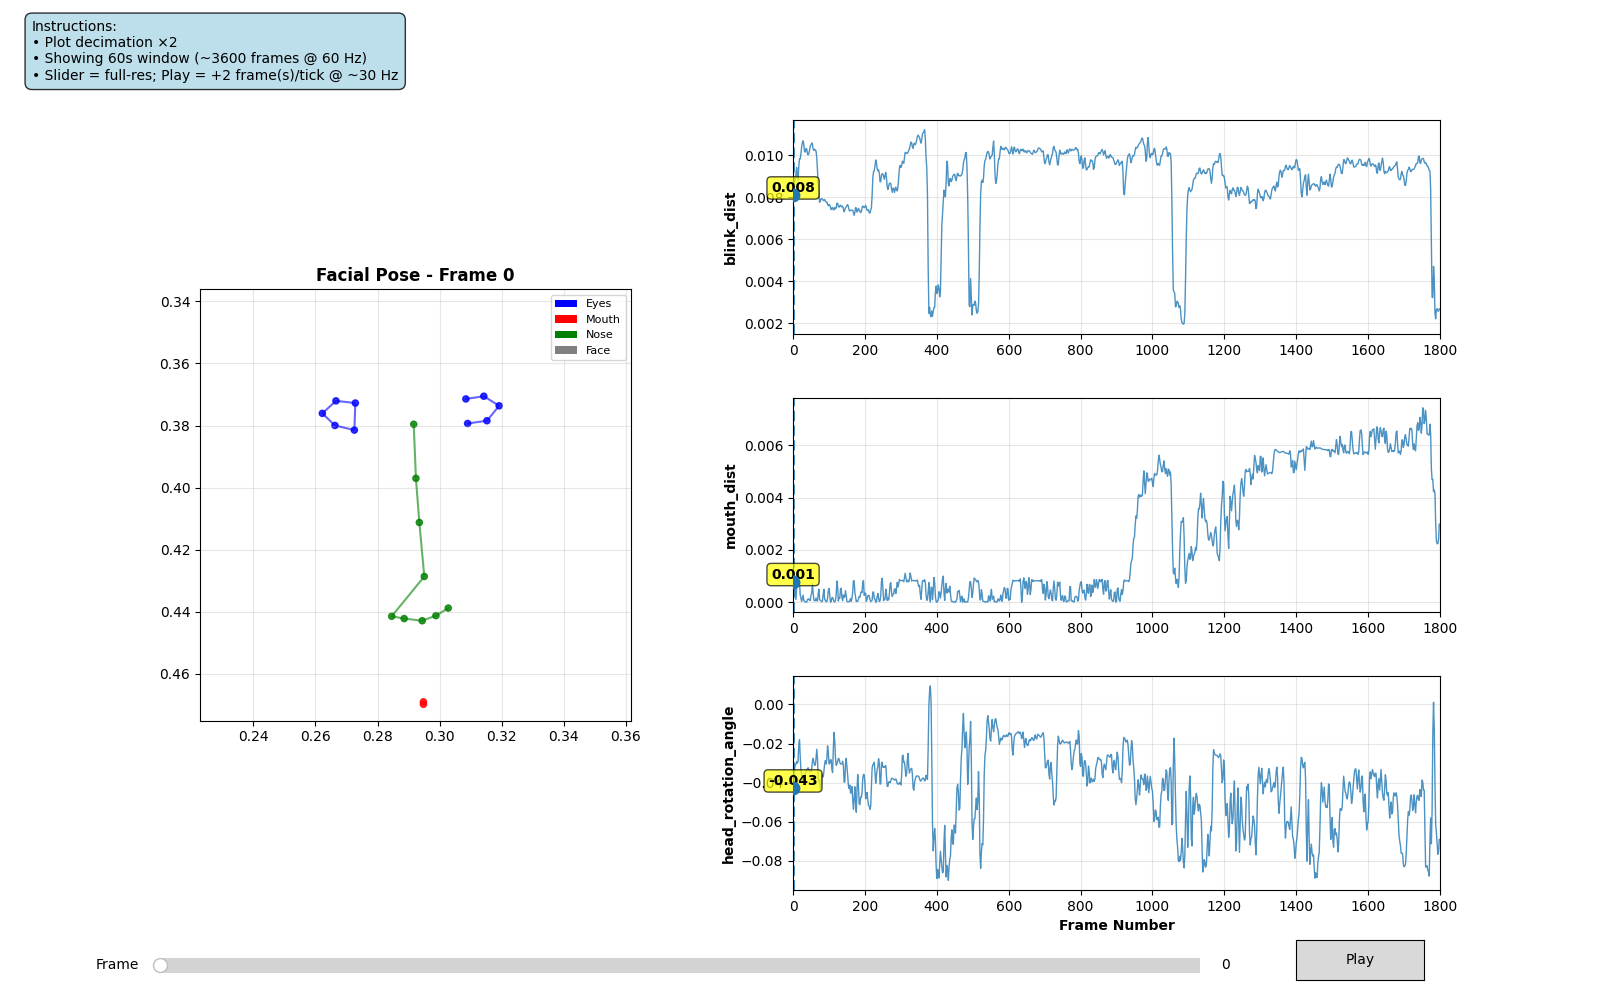

Viewer ready — participant 3213, condition M


In [12]:
# === Viewer: Procrustes (Participant) aligned time-series viewer ===
%matplotlib widget
import pandas as pd
from pathlib import Path
from utils import CFG
from utils.nb_utils import pick_norm_file, slice_first_seconds
from utils.viz_utils import procrustes_transform_series, create_interactive_pose_timeseries_viewer
from utils.io_utils import parse_participant_condition

norm_path = pick_norm_file(CFG.OUT_BASE)
if norm_path is None:
    raise FileNotFoundError("No normalized file found; run normalization first.")

df_norm_full = pd.read_csv(norm_path)
df_norm_60 = slice_first_seconds(df_norm_full, CFG.FPS, 60)

name = Path(norm_path).name
try:
    # first try the strict parser
    pid, cond = parse_participant_condition(name)
except ValueError:
    # relax: strip common suffixes, then re-parse or split
    stem = Path(norm_path).stem  # e.g., "3213_M_norm"
    for suf in ("_original_norm", "_procrustes_norm", "_norm"):
        if stem.endswith(suf):
            stem = stem[:-len(suf)]
            break
    # now try strict parse again on a reconstructed "<pid>_<cond>.csv"
    try:
        pid, cond = parse_participant_condition(stem + ".csv")
    except ValueError:
        parts = stem.split("_")
        if len(parts) >= 2:
            pid, cond = parts[0], parts[1]
        else:
            raise ValueError(f"Cannot infer participant/condition from filename: {name}")

templ_path = Path(CFG.OUT_BASE) / "templates" / f"participant_{pid}_template.csv"
templ_df = pd.read_csv(templ_path)

df_pose_part, feats_part = procrustes_transform_series(df_norm_60, templ_df)
df_feats_part = pd.DataFrame(feats_part)

fig_part = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose_part,
    df_features=df_feats_part,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=CFG.FPS,
    plot_downsample=2,
    window_seconds=60
)

print(f"Viewer ready — participant {pid}, condition {cond}")


## 6. Linear Metrics Analysis

### Calculate Linear Metrics (windowing & interocular scaling)
What this cell does:
- Uses the per-frame per-participant CSVs stored under `OUT_BASE/features/per_frame/procrustes_participant/`.
- Computes windowed linear metrics using a sliding window defined by:
    - `CFG.WINDOW_SECONDS` (typically 60 s),
    - `CFG.WINDOW_OVERLAP` (e.g., 0.5 for 50% overlap).
- Each output row corresponds to a single window for a single participant/condition, and contains aggregation measures such as RMS, mean absolute velocity, mean absolute acceleration, counts/durations, and interocular-scaled variants (if `SCALE_BY_INTEROCULAR` is `True`)

Important parameters / behavior:
- `SCALE_BY_INTEROCULAR` — if set, spatial features are normalized by the subject’s inter-ocular distance; this reduces between-subject scale differences.
- Window hop is computed as `hop = int(win * (1.0 - overlap))` (or at least 1).
- The function `compute_linear_from_perframe_dir` returns a summary of any windows that were dropped due to insufficient data.

In [8]:
# Compute linear metrics (60 s windows, 50% overlap) — fixed scale-by-interocular lookup
from pathlib import Path
import pandas as pd
import pose_pipeline as pp
from utils import CFG
from utils.features_utils import compute_linear_from_perframe_dir

# ---- interactive toggles ----
OVERWRITE = True   # set True to force recompute/overwrite existing linear CSVs
CFG.WINDOW_SECONDS = 60 # 60 second windows
CFG.WINDOW_OVERLAP = 0.5 # 50% overlap

# Paths
perframe_dir = Path(CFG.OUT_BASE) / "features" / "per_frame" / "procrustes_participant"
lm_out_dir = Path(CFG.OUT_BASE) / "linear_metrics"
lm_out_dir.mkdir(parents=True, exist_ok=True)
lm_out_path = lm_out_dir / "procrustes_participant_linear.csv"

compat_path = Path("data") / "linear_pose_metrics.csv"
compat_path.parent.mkdir(parents=True, exist_ok=True)

# Sanity checks
if not perframe_dir.exists() or not any(perframe_dir.glob("*.csv")):
    raise FileNotFoundError(f"No per-frame Procrustes files found in {perframe_dir}. Run per-frame feature extraction first.")

# Determine SCALE_BY_INTEROCULAR flag robustly
try:
    # prefer explicit export from utils if present
    from utils import SCALE_BY_INTEROCULAR as _SCALE_FLAG
except Exception:
    _SCALE_FLAG = getattr(pp, "SCALE_BY_INTEROCULAR", False)

print(f"Using SCALE_BY_INTEROCULAR = {_SCALE_FLAG}")

# If exists and not OVERWRITE, skip
if lm_out_path.exists() and not OVERWRITE:
    print(f"[skip] linear metrics exists -> {lm_out_path} (set OVERWRITE=True to force recompute)")
else:
    print(f"[run] computing linear metrics from per-frame dir -> {perframe_dir}")
    drops = compute_linear_from_perframe_dir(
        perframe_dir,
        lm_out_path,
        CFG.FPS,
        CFG.WINDOW_SECONDS,
        CFG.WINDOW_OVERLAP,
        _SCALE_FLAG
    )
    print(f"[OK] wrote linear metrics -> {lm_out_path}")
    print("Window drops summary:", drops)

# Write compatibility copy used by plotting/stats (overwrite if OVERWRITE=True or if missing)
if not compat_path.exists() or OVERWRITE:
    df_lin = pd.read_csv(lm_out_path)
    df_lin.to_csv(compat_path, index=False)
    print(f"[OK] wrote compatibility copy -> {compat_path}")
else:
    print(f"[skip] compatibility copy exists -> {compat_path}")

# Preview
display(pd.read_csv(lm_out_path).head())


Using SCALE_BY_INTEROCULAR = True
[run] computing linear metrics from per-frame dir -> data/processed/features/per_frame/procrustes_participant
[OK] wrote linear metrics -> data/processed/linear_metrics/procrustes_participant_linear.csv
Window drops summary: {}
[OK] wrote compatibility copy -> data/linear_pose_metrics.csv


,source,participant,condition,window_index,t_start_frame,t_end_frame,head_rotation_rad_mean_abs_vel,head_rotation_rad_mean_abs_acc,head_rotation_rad_rms,head_tx_mean_abs_vel,...,mouth_aperture_rms,pupil_dx_mean_abs_vel,pupil_dx_mean_abs_acc,pupil_dx_rms,pupil_dy_mean_abs_vel,pupil_dy_mean_abs_acc,pupil_dy_rms,pupil_metric_mean_abs_vel,pupil_metric_mean_abs_acc,pupil_metric_rms
0,procrustes_participant,3213,M,0,0,3600,0.143716,5.593214,0.017690,0.398725,...,0.041389,0.041200,1.670171,0.004896,0.072356,2.866310,0.008028,0.048494,2.032783,0.004923
1,procrustes_participant,3213,M,1,1800,5400,0.140074,5.540635,0.026180,0.410659,...,0.018376,0.041436,1.630636,0.005094,0.074694,2.957232,0.008259,0.049139,2.060989,0.004725
2,procrustes_participant,3213,M,2,3600,7200,0.148908,5.745722,0.025356,0.383400,...,0.042708,0.041932,1.640189,0.004745,0.068655,2.716197,0.007694,0.047751,2.007904,0.004034
3,procrustes_participant,3213,M,3,5400,9000,0.167357,6.108989,0.028397,0.413402,...,0.058017,0.043721,1.751640,0.004536,0.071967,2.857238,0.008018,0.047354,2.031521,0.004104
4,procrustes_participant,3213,M,4,7200,10800,0.156811,5.957507,0.030360,0.427877,...,0.029053,0.043757,1.768405,0.004770,0.075080,2.985544,0.008728,0.048384,2.035364,0.004880


### Figures and Stats (LMER)
What this cell does:
- Loads the Procrustes (per Participant) linear metrics CSV.
- Prepares an interactive small GUI that allows the reviewer to:
    - select two metrics to visualize side-by-side (the figure layout mirrors the paper-style figures),
    - run the linear mixed model (LMER) for each selected metric using `lmerTest::lmer` in R via `rpy2`,
    - display `emmeans` results (condition means with CIs) and pairwise Tukey-adjusted contrasts,
    - or fall back to simple group means + 95% CIs if the R model fails (so you always get a plot for inspection).

In [11]:
# Interactive picker using window_index directly (no minute anywhere)
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, clear_output
import ipywidgets as widgets
import warnings
import traceback
import math

from utils import CFG
from utils.stats_utils import run_lmer_rpy2, barplot_ax

# --- load and prepare linear pose CSV (Global Procrustes) ---
pose_path = Path("data/processed/linear_metrics") / "procrustes_participant_linear.csv"
if not pose_path.exists():
    raise FileNotFoundError(f"Global Procrustes linear metrics not found at {pose_path}; run the Procrustes linear computation step first.")

pose_df = pd.read_csv(pose_path)
print(f"[Global Procrustes] Loaded pose_df: {pose_df.shape[0]} rows x {pose_df.shape[1]} cols")


pose_df = pd.read_csv(pose_path)
print(f"Loaded pose_df: {pose_df.shape[0]} rows x {pose_df.shape[1]} cols")

# Ensure participant col exists
if "participant" not in pose_df.columns:
    if "Participant ID" in pose_df.columns:
        pose_df = pose_df.rename(columns={"Participant ID": "participant"})
        print("Renamed 'Participant ID' -> 'participant'")
    else:
        raise KeyError("No 'participant' or 'Participant ID' column found in linear_pose_metrics.csv")

# drop sentinel window_index rows if present
if "window_index" in pose_df.columns:
    pose_df = pose_df[pose_df["window_index"] != 15]

# session ordering via participant_info.csv if present
session_info_path = Path("data") / "participant_info.csv"
session_order_map = {}
session_order_numeric_map = {"LMH": 1, "LHM": 2}
if session_info_path.exists():
    si = pd.read_csv(session_info_path)
    if {"Session1", "Session2", "Session3"}.issubset(si.columns):
        si["session_order"] = si["Session1"].str[0] + si["Session2"].str[0] + si["Session3"].str[0]
    if "session_order" in si.columns:
        session_order_map = si.set_index("Participant ID")["session_order"].to_dict()
        observed = sorted(si["session_order"].dropna().unique().tolist())
        if set(["LMH", "LHM"]).issubset(set(observed)):
            session_order_numeric_map = {"LMH": 1, "LHM": 2}
        else:
            session_order_numeric_map = {v: i+1 for i, v in enumerate(observed)}

# Ensure window_index exists / is numeric (we keep window_index; no minute)
if "window_index" not in pose_df.columns:
    pose_df["window_index"] = 0
    warnings.warn("No 'window_index' column found: setting window_index = 0 for all rows")
pose_df["window_index"] = pd.to_numeric(pose_df["window_index"], errors="coerce").fillna(0).astype(int)

# map session_order if available (and create numeric)
if session_order_map:
    pose_df["session_order"] = pose_df["participant"].map(session_order_map)
    pose_df["session_order_numeric"] = pose_df["session_order"].map(session_order_numeric_map).fillna(0).astype(float)
    print("Mapped session_order and session_order_numeric from participant_info.csv")
else:
    if "session_order_numeric" not in pose_df.columns:
        pose_df["session_order_numeric"] = 0.0
        warnings.warn("No participant_info.csv: setting session_order_numeric = 0 for all rows")
    else:
        pose_df["session_order_numeric"] = pd.to_numeric(pose_df["session_order_numeric"], errors="coerce").fillna(0.0)

# standardize condition column
cond_map = {"low": "L", "moderate": "M", "hard": "H", "l": "L", "m": "M", "h": "H"}
if "condition" in pose_df.columns:
    pose_df["condition"] = pose_df["condition"].astype(str).str.strip().str.lower().map(cond_map).fillna(pose_df["condition"])
else:
    warnings.warn("No 'condition' column found — model may not behave as intended")

# --- candidate numeric columns for selection: exclude control columns ---
non_metric_cols = {"participant", "condition", "window_index", "session_order", "session_order_numeric"}
candidates = [c for c in pose_df.columns if c not in non_metric_cols and pd.api.types.is_numeric_dtype(pose_df[c])]
if not candidates:
    raise RuntimeError("No numeric candidate metrics found in linear_pose_metrics.csv")

# Build widgets
w_metric1 = widgets.Dropdown(options=candidates, value=candidates[0], description="Metric 1:")
w_metric2 = widgets.Dropdown(options=candidates, value=(candidates[1] if len(candidates)>1 else candidates[0]), description="Metric 2:")
w_run = widgets.Button(description="Run stats & plot", button_style="primary")
out = widgets.Output(layout={"border": "1px solid gray", "max_height":"600px", "overflow":"auto"})

# Interactive run code with fallback to group means on R failure
run_code = r"""
clear_output(wait=True)
display(widgets.HBox([w_metric1, w_metric2, w_run]))
display(out)
with out:
    out.clear_output()
    import math, sys, traceback
    print(f"Running stats for: {w_metric1.value}  and  {w_metric2.value}\n")
    selected = [w_metric1.value, w_metric2.value]
    metrics_labels = []
    results = {}
    for metric in selected:
        label = metric.replace("_", " ").title()
        metrics_labels.append((metric, label))
        if metric not in pose_df.columns:
            print(f"[WARN] {metric} missing from dataframe — skipping")
            results[metric] = {"pvals": {}, "means": {}, "cis": {}}
            continue

        # prepare df_model which exposes window_index & session_order_numeric to R exactly as needed
        df_model = pose_df.copy()
        df_model["window_index"] = pd.to_numeric(df_model["window_index"], errors="coerce").fillna(0.0).astype(float)
        df_model["session_order_numeric"] = pd.to_numeric(df_model.get("session_order_numeric", 0), errors="coerce").fillna(0.0).astype(float)

        # Attempt the R model; capture exceptions and print traceback / repr(e)
        try:
            pairwise_p, means, cis = run_lmer_rpy2(df_model, metric, label)
            # If returned dicts are empty or missing 'means' treat as failure to be safe
            if not means:
                raise RuntimeError("run_lmer_rpy2 returned empty results")
            results[metric] = {"pvals": pairwise_p, "means": means, "cis": cis}
            print(f"[OK] R model succeeded for {metric}\n")
        except Exception as e:
            print(f"[ERROR] R model failed for {metric}: {e}\n")
            traceback.print_exc()
            # FALLBACK: compute simple group means and 95% CI (sem*1.96) for condition groups
            try:
                grp = df_model.groupby("condition", observed=False)[metric]
                means_pd = grp.mean()
                sem_pd = grp.sem(ddof=0)
                # build outputs keyed by 'L','M','H'
                means = {}
                cis = {}
                for lvl in ["L","M","H"]:
                    if lvl in means_pd.index:
                        m = float(means_pd.loc[lvl])
                        se = float(sem_pd.loc[lvl]) if (lvl in sem_pd.index) else float("nan")
                        means[lvl] = m
                        cis[lvl] = (m - 1.96*se if not math.isnan(se) else float("nan"),
                                    m + 1.96*se if not math.isnan(se) else float("nan"))
                    else:
                        means[lvl] = float("nan")
                        cis[lvl] = (float("nan"), float("nan"))
                # pairwise pvals: set NaN (we didn't compute)
                pairwise_p = {}
                results[metric] = {"pvals": pairwise_p, "means": means, "cis": cis}
                print("[FALLBACK] Plotted group means + 95% CI (sem*1.96). This is NOT the LMER result.\n")
            except Exception as e2:
                print(f"[ERROR] Fallback summary failed for {metric}: {e2}\n")
                results[metric] = {"pvals": {}, "means": {}, "cis": {}}

    # Now plot side-by-side using barplot_ax (same formatting)
    col_pal = ['#c6dbef', '#6baed6', '#2171b5']
    FIGSIZE = (6, 3)
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, sharey=False, constrained_layout=True)

    for ax, (metric, label) in zip(axes, metrics_labels):
        res = results.get(metric, {"pvals": {}, "means": {}, "cis": {}})
        # If we have no means at all -> message and grey panel
        if not res["means"] or all(math.isnan(v) for v in res["means"].values()):
            ax.text(0.5, 0.5, f"Missing results for {metric}", ha='center', va='center')
            ax.set_axis_off()
            continue
        order = ['L', 'M', 'H']
        means = [res["means"].get(lvl, math.nan) for lvl in order]
        cis = [res["cis"].get(lvl, (math.nan, math.nan)) for lvl in order]
        sems = []
        for ci in cis:
            if ci is not None and isinstance(ci, (tuple, list)) and len(ci) == 2 and not math.isnan(ci[0]) and not math.isnan(ci[1]):
                sems.append((ci[1] - ci[0]) / 3.92)
            else:
                sems.append(math.nan)
        pvals = (
            res["pvals"].get(('L','M'), math.nan),
            res["pvals"].get(('L','H'), math.nan),
            res["pvals"].get(('M','H'), math.nan)
        )
        barplot_ax(ax, means, sems, pvals, label, metric_name=metric, colors=col_pal, bar_width=0.6)

    fig.suptitle("Pose measures", fontweight='bold', fontsize=16)
    plt.show()
"""

# attach on_click using a lambda that execs the run_code in the current scope
w_run.on_click(lambda b: exec(run_code, globals(), locals()))

# display UI
display(widgets.HBox([w_metric1, w_metric2, w_run]))
display(out)

Output(layout=Layout(border_bottom='1px solid gray', border_left='1px solid gray', border_right='1px solid gra…